In [596]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


In [596]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


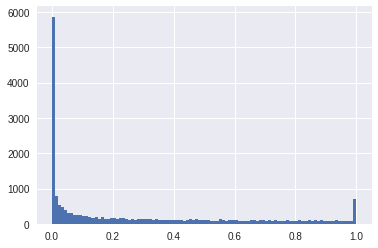

In [780]:
plt.hist(results['mean_256_pvalues'].flatten(),bins=100)
plt.show()

This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

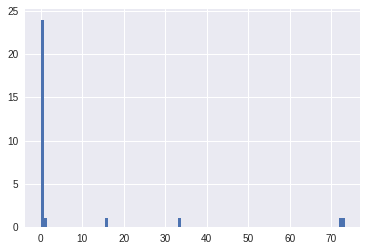

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 

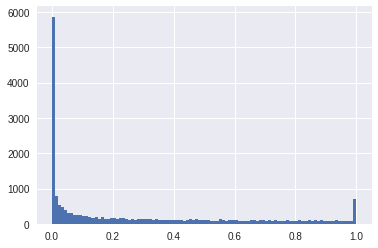

In [780]:
plt.hist(results['mean_256_pvalues'].flatten(),bins=100)
plt.show()

This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

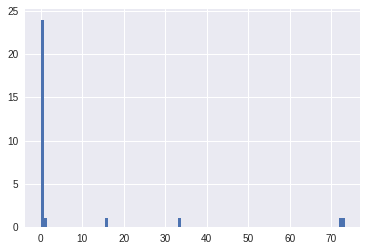

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 